In [1]:
import pandas as pd
from typing import Optional
from pathlib import Path
import gzip
import matplotlib.pyplot as plt

# 1. Read datasets
Use the gzip function is files ar gzipped

In [2]:
def read_ds_gzip(path: Optional[Path]=None, ds: str = "TRAIN") -> pd.DataFrame:
    """Args:
        path (Optional[Path], optional): the path to read the dataset file. Defaults to /kaggle/input/the-insa-starcraft-2-player-prediction-challenge/{ds}.CSV.gz.
        ds (str, optional): the part to read (TRAIN or TEST), to use when path is None. Defaults to "TRAIN".

    Returns:
        pd.DataFrame:
    """
    with gzip.open(f'/kaggle/input/the-insa-starcraft-2-player-prediction-challenge/{ds}.CSV.gz' if path is None else path) as f:
        max_actions = max(( len( str(c).split(",")) for c in f.readlines() ))
        f.seek(0)
        _names = ["battleneturl", "played_race"] if "TRAIN" in ds else ["played_race"]
        _names.extend(range(max_actions - len(_names)))
        return pd.read_csv(f, names=_names, dtype= str)

def read_ds(path: Optional[Path]=None, ds: str = "TRAIN"):
    """Args:
        path (Optional[Path], optional): the path to read the dataset file. Defaults to /kaggle/input/the-insa-starcraft-2-player-prediction-challenge/{ds}.CSV.gz.
        ds (str, optional): the part to read (TRAIN or TEST), to use when path is None. Defaults to "TRAIN".

    Returns:
        pd.DataFrame:
    """
    with open(f'/kaggle/input/train-sc2-keystrokes/{ds}.CSV' if path is None else path) as f:
        max_actions = max(( len( str(c).split(",")) for c in f.readlines() ))
        f.seek(0)
        _names = ["battleneturl", "played_race"] if "TRAIN" in ds else ["played_race"]
        _names.extend(range(max_actions - len(_names)))
        return pd.read_csv(f, names=_names, dtype= str)

In [3]:
def url_to_code(df: pd.DataFrame, col: str="battleneturl") -> None:
    """Convert url col of df to a categorical column and return the code to url dict"""
    df["battleneturl"] = pd.Categorical(df["battleneturl"])
    df["battlenetcode"] = df[[col]].apply(lambda x: x.cat.codes)
    code_to_url = dict(zip(df["battlenetcode"], df["battleneturl"]))
    df["battleneturl"] = df["battlenetcode"]
    df.drop(columns=["battlenetcode"], inplace=True)
    return code_to_url
    

In [4]:
train_ds = read_ds_gzip(Path("data/TRAIN.CSV.GZ"))
url_dict = url_to_code(train_ds)

In [5]:
train_ds.head()

,battleneturl,played_race,0,1,2,3,4,5,6,7,...,10527,10528,10529,10530,10531,10532,10533,10534,10535,10536
0,53,Protoss,Base,s,s,s,s,s,t5,Base,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,29,Protoss,s,Base,s,s,Base,s,s,Base,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,53,Protoss,Base,s,s,s,Base,s,hotkey30,hotkey00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,29,Protoss,Base,s,s,Base,s,s,s,t5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,53,Protoss,Base,s,s,s,Base,s,hotkey30,hotkey00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
test_ds = read_ds_gzip(Path("data/TEST.CSV.GZ"), ds="TEST")

In [7]:
test_ds.head()

,played_race,0,1,2,3,4,5,6,7,8,...,6807,6808,6809,6810,6811,6812,6813,6814,6815,6816
0,Zerg,s,s,s,hotkey10,s,hotkey60,s,hotkey00,s,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Terran,s,hotkey30,hotkey00,t5,s,hotkey32,s,hotkey32,s,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Protoss,Base,s,s,Base,s,hotkey20,hotkey30,hotkey60,hotkey40,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Zerg,s,s,s,s,hotkey20,s,hotkey40,t5,t10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Protoss,Base,s,s,Base,s,hotkey50,hotkey30,t5,hotkey40,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
print(f"Train dataset shape: {train_ds.shape}, Test dataset shape: {test_ds.shape}")

Train dataset shape: (3052, 10539), Test dataset shape: (340, 6818)


# 2. Visualize the data

In [9]:
# Copy the dataset for visualization
train_ds_copy = train_ds.copy()

## 2.1 Game duration

In [10]:
def compute_durations(dataset: pd.DataFrame) -> pd.DataFrame:
    durations = []

    # Iterate over each row in the dataframe
    for _, row in dataset.iterrows():
        # Convert the row to a list (strings, possibly some NaN if missing)
        row_list = row.tolist()

        # Filter columns that start with "t" (e.g., "t10", "t120", etc.)
        time_tokens = [
            col for col in row_list if isinstance(col, str) and col.startswith("t")
        ]

        if time_tokens:
            # Get the last time token in the row
            last_time_token = time_tokens[-1]
            # Convert from e.g. "t135" -> integer 135
            duration = int(last_time_token[1:])
            durations.append(duration)
        else:
            # If no time tokens, we can append None or skip.
            durations.append(None)
    
    return durations

Number of rows with missing duration: 10


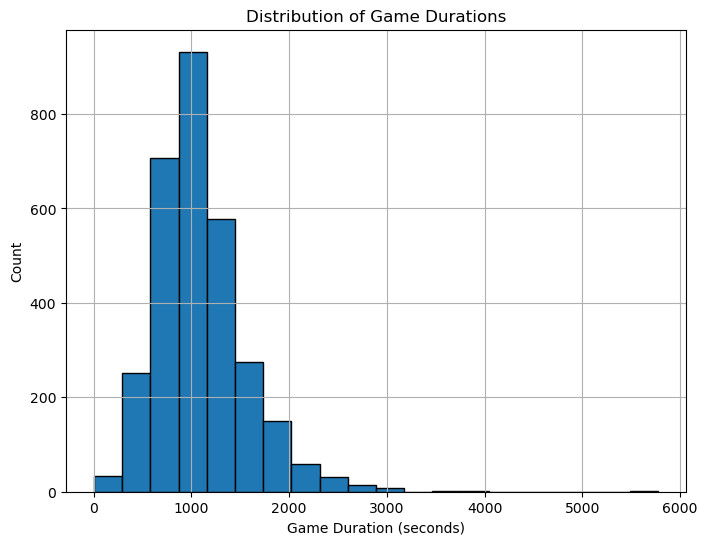

In [11]:
train_ds_copy["duration"] = compute_durations(train_ds_copy)

# Print nb of rows with missing duration
print(f"Number of rows with missing duration: {train_ds_copy['duration'].isna().sum()}")

# Drop rows without a valid duration
train_ds_copy.dropna(subset=["duration"], inplace=True)

# Plot the distribution as a histogram
plt.figure(figsize=(8, 6))
train_ds_copy["duration"].plot(kind="hist", bins=20, edgecolor="black")
plt.title("Distribution of Game Durations")
plt.xlabel("Game Duration (seconds)")
plt.ylabel("Count")
plt.grid(True)
plt.show()

## 2.1 Global statistics

In [12]:
# Display global statistics about the dataset
print("Total number of rows (games):", len(train_ds_copy))

# If you have a unique player identifier (e.g. 'battleneturl')
if "battleneturl" in train_ds_copy.columns:
    print("Number of unique players:", train_ds_copy["battleneturl"].nunique())

# If you have a race column (e.g. 'played_race')
if "played_race" in train_ds_copy.columns:
    print("Number of unique races:", train_ds_copy["played_race"].nunique(), "\n")
    print("=== Race Distribution ===\n", train_ds_copy["played_race"].value_counts(), "\n")

# Basic statistics for durations
if "duration" in train_ds_copy.columns:
    print("=== Duration Summary ===")
    print(train_ds_copy["duration"].agg(["min", "max", "mean", "std"]))

    # Example: Group by race to see duration stats per race
    if "played_race" in train_ds_copy.columns:
        print("\n=== Duration by Race ===")
        print(train_ds_copy.groupby("played_race")["duration"].agg(["min", "max", "mean", "std"]))


Total number of rows (games): 3042
Number of unique players: 200
Number of unique races: 3 

=== Race Distribution ===
 played_race
Protoss    1208
Zerg       1056
Terran      778
Name: count, dtype: int64 

=== Duration Summary ===
min        5.000000
max     5770.000000
mean    1092.041420
std      472.500389
Name: duration, dtype: float64

=== Duration by Race ===
              min     max         mean         std
played_race                                       
Protoss       5.0  3805.0  1051.672185  434.351665
Terran       10.0  5770.0  1148.560411  473.947642
Zerg         10.0  5770.0  1096.581439  507.945177


The most played race is Protoss, followed by Zerg and Terran. Overall the distribution is balanced.

In duration, there are outliers in the data that should be removed.

# 3. Preprocessing

## 3.1 Preprocessing functions

In [13]:
def filter_duration(dataset: pd.DataFrame, min_quantile:float = 0.02, max_quantile: float = 0.98, train : bool = True)-> None:
    """Filters out the rows with durations outside the specified quantiles."""
    dataset["duration"]  = compute_durations(dataset)
    if train:
        dataset.dropna(subset=["duration"], inplace=True)
        q_min = dataset["duration"].quantile(min_quantile)
        q_max = dataset["duration"].quantile(max_quantile)

        mask = (dataset['duration'] >= q_min) & (dataset['duration'] <= q_max)
        dataset.drop(index=dataset[~mask].index, inplace=True)

    # Visualize the distribution of durations
    plt.figure(figsize=(8, 6))
    dataset['duration'].plot(kind='hist', bins=20, edgecolor='black')
    plt.title('Distribution of Game Durations')
    plt.xlabel('Game Duration (seconds)')
    plt.ylabel('Count')
    plt.grid(True)
    plt.show()
    
    # Drop the duration column
    dataset.drop(columns=["duration"], inplace=True)


In [14]:
def get_dummies(df: pd.DataFrame, columns: list = ["played_race"]) -> pd.DataFrame:
    """Converts textual columns to one-hot encoded vectors (one column per possible value)"""
    df = pd.get_dummies(df, columns=columns)
    
    return df

In [15]:
def action_cols_to_list(df: pd.DataFrame, train: bool = True) -> None:
    """Converts the action columns to a list of actions column"""
    # Make a deep copy to avoid the SettingWithCopyWarning
    # df = df.copy()

    # Now safely do your assignments
    action_cols = df.columns[2 if train else 1:]
    df["actions"] = (
        df[action_cols]
        .apply(lambda row: [x for x in row if pd.notna(x)], axis=1)
    )

    df.drop(columns=action_cols, inplace=True)

In [16]:
def preprocess_dataset(df: pd.DataFrame, train: bool = True) -> pd.DataFrame:
    """Preprocess the dataset"""
    processed_df = df.copy()
    filter_duration(processed_df, train=train)
    action_cols_to_list(processed_df, train)
    return get_dummies(processed_df)

## 3.2 Apply preprocessing steps

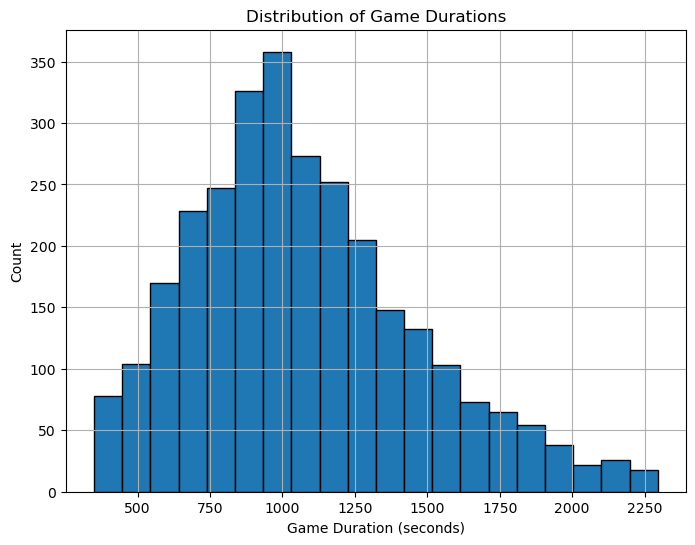

In [17]:
filtered_train_ds = preprocess_dataset(train_ds)

In [18]:
filtered_train_ds.head()

,battleneturl,actions,played_race_Protoss,played_race_Terran,played_race_Zerg
0,53,"[Base, s, s, s, s, s, t5, Base, s, hotkey30, h...",True,False,False
1,29,"[s, Base, s, s, Base, s, s, Base, s, t5, hotke...",True,False,False
2,53,"[Base, s, s, s, Base, s, hotkey30, hotkey00, t...",True,False,False
3,29,"[Base, s, s, Base, s, s, s, t5, Base, s, hotke...",True,False,False
4,53,"[Base, s, s, s, Base, s, hotkey30, hotkey00, t...",True,False,False


# 4. Feature extraction

## 4.1 Feature extraction functions

In [19]:
def chunkify_actions(action_list : list):
    """
    Given a list of actions (e.g., ["Base", "s", "s", "t5", "hotkey30", "t10", ...]),
    produce a list of tuples (start_time, end_time, actions_in_chunk).
    If we see 't5', that means the chunk boundary is 5 seconds, etc.
    """
    chunks = []
    current_time = 0
    chunk_actions = []

    def parse_time_marker(a):
        # e.g. 't5' -> int("5")
        return int(a[1:])

    for a in action_list:
        if a.startswith("t"):
            # We hit a time boundary
            end_time = parse_time_marker(a)
            if chunk_actions:
                chunks.append((current_time, end_time, chunk_actions))
            # Move forward
            current_time = end_time
            chunk_actions = []
        else:
            # It's a normal action
            chunk_actions.append(a)

    # If leftover actions exist after the last tXX
    # We'll treat them as from current_time to current_time (0-length),
    # or you can define a “max game time” if known. For now, let's store them anyway.
    if chunk_actions:
        chunks.append((current_time, current_time, chunk_actions))

    return chunks


In [20]:
def compute_features_per_chunk(chunks):
    """
    Given a list of (start_t, end_t, actions_in_chunk),
    classify them into early/mid/late, count relevant actions,
    compute average in each phase.
    """
    # Phase boundaries
    EARLY_MAX = 360  # 6 minutes
    MID_MAX = 720  # 12 minutes

    # We'll accumulate total counts and total durations (in seconds) for each phase
    phases = ["early", "mid", "late"]

    base_keys = {
        "hk_created": 0,
        "hk_updated": 0,
        "hk_used":    0,
        "base":       0,
        "mineral":    0,
        "other":      0
    }

    phase_counts = {
        ph: {
            **{f"hk_{i}": 0 for i in range(10)},
            **base_keys
        }
        for ph in phases
    }

    phase_durations = {ph: 0 for ph in phases}

    def get_phase(t):
        if t < EARLY_MAX:
            return "early"
        elif t < MID_MAX:
            return "mid"
        else:
            return "late"

    for start_t, end_t, acts in chunks:
        # Simple approach: classify chunk by its start time (some people use midpoint)
        phase = get_phase(start_t)
        # Avoid zero durations => set it to at least 1 second
        duration = max(1, end_t - start_t)

        # Count actions in this chunk
        c_hk_pressed = {f"c_hk_{i}": 0 for i in range(10)}
        c_hk_created = 0
        c_hk_updated = 0
        c_hk_used = 0
        c_base = 0
        c_mineral = 0
        c_other = 0

        for a in acts:
            if a.startswith("hotkey"):
                key = int(a[-2])
                c_hk_pressed[f"c_hk_{key}"] += 1
                # check last char if it is "0","1","2"
                if a.endswith("0"):
                    c_hk_created += 1
                elif a.endswith("1"):
                    c_hk_updated += 1
                elif a.endswith("2"):
                    c_hk_used += 1
            elif a in ["sBase", "Base"]:
                c_base += 1
            elif a in ["sMineral", "SingleMineral"]:
                c_mineral += 1
            elif a == "s":
                c_other += 1
            else:
                # some other action not relevant here
                pass

        for i in range(10):
            phase_counts[phase][f"hk_{i}"] += c_hk_pressed[f"c_hk_{i}"]
        phase_counts[phase]["hk_created"] += c_hk_created
        phase_counts[phase]["hk_updated"] += c_hk_updated
        phase_counts[phase]["hk_used"] += c_hk_used
        phase_counts[phase]["base"] += c_base
        phase_counts[phase]["mineral"] += c_mineral
        phase_counts[phase]["other"] += c_other

        phase_durations[phase] += duration

    # Now compute the final average for each phase
    # e.g.  (count / total_duration_in_phase)
    feats = {}
    for phase in ["early", "mid", "late"]:
        dur = phase_durations[phase]
        pc = phase_counts[phase]
        if dur == 0:
            # no data for that phase
            for i in range(10):
                feats[f"{phase}_hotkey_{i}"] = 0
            feats[f"{phase}_hotkey_created"] = 0
            feats[f"{phase}_hotkey_updated"] = 0
            feats[f"{phase}_hotkey_used"] = 0
            feats[f"{phase}_base"] = 0
            feats[f"{phase}_mineral"] = 0
            feats[f"{phase}_other"] = 0
        else:
            for i in range(10):
                feats[f"{phase}_hotkey_{i}"] = (pc[f"hk_{i}"] / dur)
            feats[f"{phase}_hotkey_created"] = (pc["hk_created"] / dur)
            feats[f"{phase}_hotkey_updated"] = (pc["hk_updated"] / dur)
            feats[f"{phase}_hotkey_used"] = (pc["hk_used"] / dur)
            feats[f"{phase}_base"] = (pc["base"] / dur)
            feats[f"{phase}_mineral"] = (pc["mineral"] / dur)
            feats[f"{phase}_other"] = (pc["other"] / dur)

    return feats

In [21]:
def compute_all_features(row):
   """
   row is a single Pandas row with:
      row["actions"] = list of action strings
      row["battleneturl"], row["played_race"], etc. if needed
   Returns a dict of feature_name -> value
   """
   chunks = chunkify_actions(row)
   feats = compute_features_per_chunk(chunks)
   
   # You can also include the player's ID or race in the returned features if desired
   return feats

In [22]:
def add_features(df: pd.DataFrame) -> pd.DataFrame:
    features_df = df["actions"].apply(compute_all_features).apply(pd.Series)

    # Combine with the original df if you like
    combined_df = pd.concat([df, features_df], axis=1)
    
    # Drop the actions column
    combined_df.drop(columns=["actions"], inplace=True)
    
    return combined_df

## 4.2 Apply feature extraction steps

In [23]:
# Apply to entire DataFrame
final_train_ds = add_features(filtered_train_ds)

print(final_train_ds.columns)

Index(['battleneturl', 'played_race_Protoss', 'played_race_Terran',
       'played_race_Zerg', 'early_hotkey_0', 'early_hotkey_1',
       'early_hotkey_2', 'early_hotkey_3', 'early_hotkey_4', 'early_hotkey_5',
       'early_hotkey_6', 'early_hotkey_7', 'early_hotkey_8', 'early_hotkey_9',
       'early_hotkey_created', 'early_hotkey_updated', 'early_hotkey_used',
       'early_base', 'early_mineral', 'early_other', 'mid_hotkey_0',
       'mid_hotkey_1', 'mid_hotkey_2', 'mid_hotkey_3', 'mid_hotkey_4',
       'mid_hotkey_5', 'mid_hotkey_6', 'mid_hotkey_7', 'mid_hotkey_8',
       'mid_hotkey_9', 'mid_hotkey_created', 'mid_hotkey_updated',
       'mid_hotkey_used', 'mid_base', 'mid_mineral', 'mid_other',
       'late_hotkey_0', 'late_hotkey_1', 'late_hotkey_2', 'late_hotkey_3',
       'late_hotkey_4', 'late_hotkey_5', 'late_hotkey_6', 'late_hotkey_7',
       'late_hotkey_8', 'late_hotkey_9', 'late_hotkey_created',
       'late_hotkey_updated', 'late_hotkey_used', 'late_base', 'late_mineral'

In [24]:
label_col = "battleneturl"
feature_cols = [c for c in final_train_ds.columns if c != label_col]

# 5. Training

In [25]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import accuracy_score
import pickle

In [26]:
print("Features:", feature_cols)
X = final_train_ds[feature_cols]
y = final_train_ds[label_col].values

# Split into train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y
)

Features: ['played_race_Protoss', 'played_race_Terran', 'played_race_Zerg', 'early_hotkey_0', 'early_hotkey_1', 'early_hotkey_2', 'early_hotkey_3', 'early_hotkey_4', 'early_hotkey_5', 'early_hotkey_6', 'early_hotkey_7', 'early_hotkey_8', 'early_hotkey_9', 'early_hotkey_created', 'early_hotkey_updated', 'early_hotkey_used', 'early_base', 'early_mineral', 'early_other', 'mid_hotkey_0', 'mid_hotkey_1', 'mid_hotkey_2', 'mid_hotkey_3', 'mid_hotkey_4', 'mid_hotkey_5', 'mid_hotkey_6', 'mid_hotkey_7', 'mid_hotkey_8', 'mid_hotkey_9', 'mid_hotkey_created', 'mid_hotkey_updated', 'mid_hotkey_used', 'mid_base', 'mid_mineral', 'mid_other', 'late_hotkey_0', 'late_hotkey_1', 'late_hotkey_2', 'late_hotkey_3', 'late_hotkey_4', 'late_hotkey_5', 'late_hotkey_6', 'late_hotkey_7', 'late_hotkey_8', 'late_hotkey_9', 'late_hotkey_created', 'late_hotkey_updated', 'late_hotkey_used', 'late_base', 'late_mineral', 'late_other']


In [27]:
param_distributions = {
    'n_estimators': [100, 200, 300, 500, 700],
    'max_depth': [10, 15, 20, 25, None],
    'min_samples_split': [2, 4, 8, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', 0.33, 0.5]
}

In [28]:
rf = RandomForestClassifier(random_state=42)

random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_distributions,
    n_iter=30,            # how many random samples of params to try
    scoring='accuracy',   # or 'f1_macro', etc., depending on your metric
    cv=5,                 # 5-fold cross-validation
    verbose=1,
    n_jobs=-1,            # use all CPU cores
    random_state=42
)

random_search.fit(X_train, y_train)
print("Best Params:", random_search.best_params_)
print("Best CV Accuracy:", random_search.best_score_)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


/home/benjamin/miniconda3/envs/tf/lib/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/home/benjamin/miniconda3/envs/tf/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best Params: {'n_estimators': 500, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'log2', 'max_depth': 15}
Best CV Accuracy: 0.9015474294917549


In [29]:
best_rf = random_search.best_estimator_
y_pred = best_rf.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred)
print(f"Random Forest Test Accuracy: {test_accuracy*100:.2f}%")

Random Forest Test Accuracy: 91.61%


In [30]:
# Save the model
with open("./resources/model.pkl", "wb") as f:
    pickle.dump(best_rf, f)

# 6. Submission

In [31]:
# Load the model
with open("./resources/model.pkl", "rb") as f:
    loaded_model = pickle.load(f)

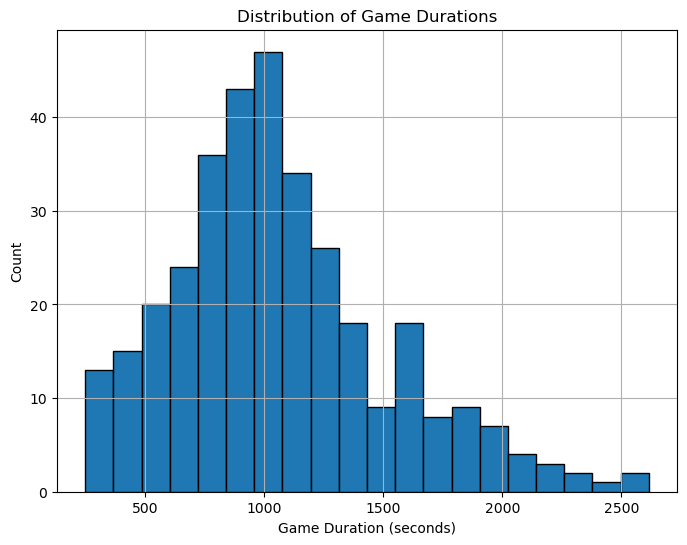

                                             actions  played_race_Protoss  \
0  [s, s, s, hotkey10, s, hotkey60, s, hotkey00, ...                False   
1  [s, hotkey30, hotkey00, t5, s, hotkey32, s, ho...                False   
2  [Base, s, s, Base, s, hotkey20, hotkey30, hotk...                 True   
3  [s, s, s, s, hotkey20, s, hotkey40, t5, t10, h...                False   
4  [Base, s, s, Base, s, hotkey50, hotkey30, t5, ...                 True   

   played_race_Terran  played_race_Zerg  
0               False              True  
1                True             False  
2               False             False  
3               False              True  
4               False             False  
(340, 4)


In [32]:
filtered_test_ds = preprocess_dataset(test_ds, train=False)
print(filtered_test_ds.head(), filtered_test_ds.shape, sep="\n")
assert filtered_test_ds.shape[0] == test_ds.shape[0], "Number of rows changed after preprocessing!"

In [33]:
final_test_ds = add_features(filtered_test_ds)
print(final_test_ds.head(), final_test_ds.shape, sep="\n")
assert final_test_ds.shape[0] == test_ds.shape[0], "Number of rows changed after adding features!"

   played_race_Protoss  played_race_Terran  played_race_Zerg  early_hotkey_0  \
0                False               False              True        1.239437   
1                False                True             False        0.011429   
2                 True               False             False        0.000000   
3                False               False              True        0.000000   
4                 True               False             False        0.005714   

   early_hotkey_1  early_hotkey_2  early_hotkey_3  early_hotkey_4  \
0        0.267606        0.047887        0.011268        0.000000   
1        0.577143        0.188571        0.874286        0.877143   
2        0.333333        0.463889        0.358333        0.161111   
3        0.331343        0.250746        0.002985        0.447761   
4        0.048571        0.074286        0.017143        0.031429   

   early_hotkey_5  early_hotkey_6  ...  late_hotkey_6  late_hotkey_7  \
0        0.000000        1.39154

In [34]:
predictions = loaded_model.predict(final_test_ds[feature_cols])

In [35]:
# Convert the array of codes to URLs using the url_dict
urls = [url_dict[code] for code in predictions]

# Create a new DataFrame with these URLs
urls_df = pd.DataFrame(urls, columns=['prediction'])

# Add a 'RowId' column starting at index 1
urls_df['RowId'] = range(1, len(urls_df) + 1)

# Set 'RowId' as the index
urls_df.set_index('RowId', inplace=True)

# Display the new DataFrame
print(urls_df.head())

                                              prediction
RowId                                                   
1      http://eu.battle.net/sc2/en/profile/3538115/1/...
2      http://eu.battle.net/sc2/en/profile/2896854/1/...
3      http://eu.battle.net/sc2/en/profile/3973341/1/...
4      http://eu.battle.net/sc2/en/profile/250458/1/V...
5      http://eu.battle.net/sc2/en/profile/950504/1/G...


In [36]:
urls_df.to_csv('submission.csv')

# 7. Evaluation

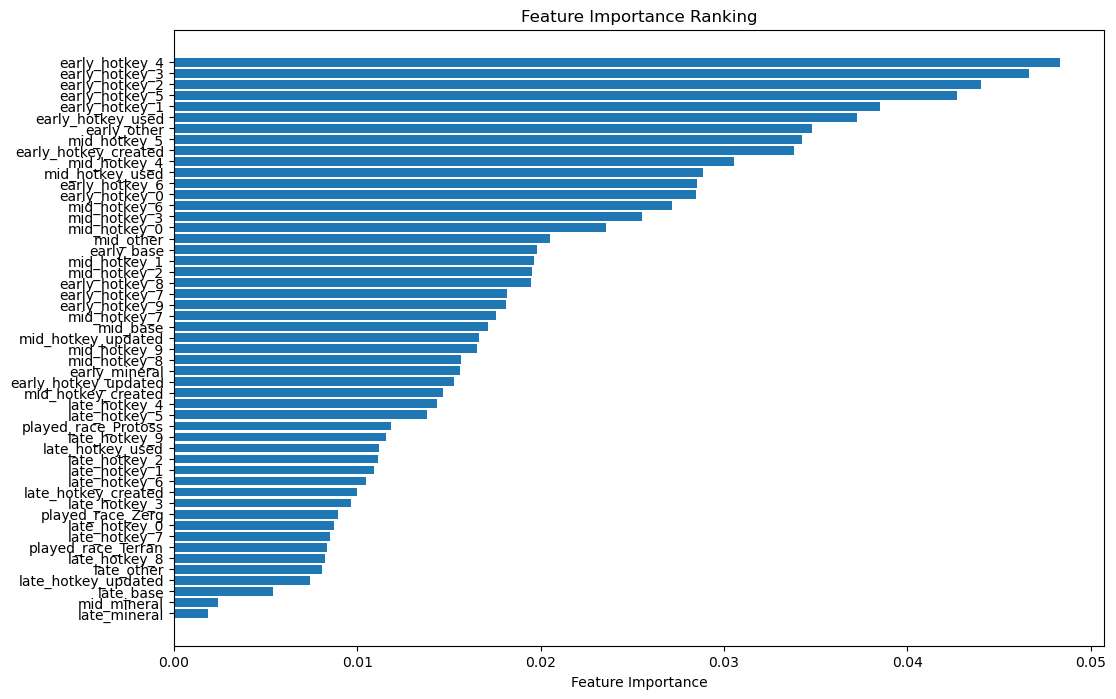

In [37]:
# Feature Importance - Mean Decrease in Impurity
importances = loaded_model.feature_importances_
feature_names = X.columns

feature_importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values(by='importance', ascending=False)

# Plot Mean Decrease in Impurity
plt.figure(figsize=(12, 8))
plt.barh(feature_importance_df['feature'], feature_importance_df['importance'])
plt.xlabel('Feature Importance')
plt.title('Feature Importance Ranking')
plt.gca().invert_yaxis()
plt.show()

/home/benjamin/miniconda3/envs/tf/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


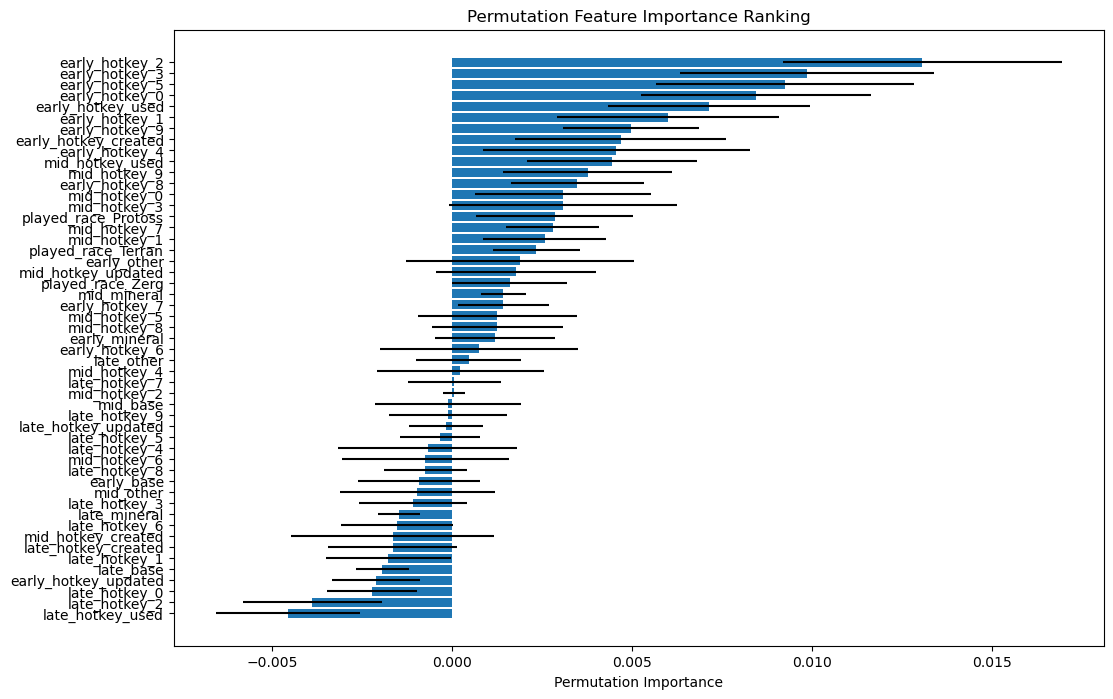

In [38]:
from sklearn.inspection import permutation_importance


# Permutation Importance
results = permutation_importance(loaded_model, X_test, y_test, scoring='accuracy', n_repeats=30, random_state=42, n_jobs=-1)

perm_importance = pd.DataFrame({
    'feature': X.columns,
    'importance_mean': results.importances_mean,
    'importance_std': results.importances_std
}).sort_values(by='importance_mean', ascending=False)

# Plot Permutation Importance
plt.figure(figsize=(12, 8))
plt.barh(perm_importance['feature'], perm_importance['importance_mean'], xerr=perm_importance['importance_std'])
plt.xlabel('Permutation Importance')
plt.title('Permutation Feature Importance Ranking')
plt.gca().invert_yaxis()
plt.show()
